In [2]:
using NBInclude
@nbinclude("Kagome SP.ipynb")

get_SP_H (generic function with 1 method)

In [4]:
using QuantumOptics

# https://juliapackages.com/p/einsum
using Einsum

using BenchmarkTools

#using LinearAlgebra

In [130]:
Nx = 8; Ny = 8; N=Nx*Ny*3; cut_off = 50
PN = [0,1,2]
U = 2
# t1=-1;L1=0 ;t2=L2=0
# t1=L1=0;t2=L2=-1
t1 = -1;L1 = 0.28;t2 = 0.3;L2 = 0.2;
# t1=t2=-1;L1=L2=0

0.2

In [131]:
sp_basis = NLevelBasis(N)
sp_matrix = get_SP_H(Nx, Ny, t1, L1, t2, L2);

In [132]:
function get_sp_op(sp_basis, sp_matrix)
  
    H = SparseOperator(sp_basis)

    for m in 1:N
        for n in 1:N
            H += sp_matrix.data[m,n] * transition(sp_basis, m, n)
        end
    end
    
    return H
end

get_sp_op (generic function with 1 method)

In [133]:
H1 = get_sp_op(sp_basis, sp_matrix);

In [134]:
#check operator form
eigenenergies(dense(H1)) == eigenenergies(dense(sp_matrix))

true

In [135]:
function get_sub_states(sp_op, cut_off)
    
    E0, states0 = eigenstates(dense(sp_op))
    states = states0[1:cut_off]
    
    return states
end

get_sub_states (generic function with 1 method)

In [136]:
sub_states = get_sub_states(H1, cut_off);

In [137]:
function get_projector_op(states, basis)
    
    b_sub = SubspaceBasis(basis,states)
    P = projector(b_sub, basis)
    Pt = dagger(P)
    
    return b_sub, P, Pt
end

get_projector_op (generic function with 1 method)

In [138]:
b_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [139]:
function get_subspace_op(sp_op, P, Pt)
    return P*sp_op*Pt
end

get_subspace_op (generic function with 1 method)

In [140]:
H1_sub = get_subspace_op(H1, P, Pt);

In [141]:
states_mb = bosonstates(b_sub, PN) 
basis_mb = ManyBodyBasis(b_sub, states_mb);

In [142]:
function get_mb_op(basis_mb, basis, sp_op)
    
    Op_MB = SparseOperator(basis_mb)
    
    for i in 1:length(basis)
        for j in 1:length(basis)
            Op_MB += sp_op.data[i,j] * transition(basis_mb, i, j)
        end
    end
    
    return Op_MB
end

get_mb_op (generic function with 1 method)

In [143]:
H1_MB = get_mb_op(basis_mb, b_sub, H1_sub);

In [144]:
@nbinclude("Kagome MB .ipynb"; regex=r"#.*executeme")

Kagome_Finite_U (generic function with 1 method)

In [145]:
function get_hubbard_int(P, Pt, b_sub, cut_off)
    
    bcut_mb = get_Bosonic_MB_Basis(cut_off, PN)
    
    @time begin
    P1 = P.data
    P1t = Pt.data;

    @einsum P4[k,l,m,n] := P1[k,i] * P1[l,i] * P1t[i,m] * P1t[i,n]

    Vint_mb_cut = SparseOperator(bcut_mb)
        
    for k in 1:cut_off
        for l in 1:cut_off
            for m in 1:cut_off
                for n in 1:cut_off
                    a1t = create(bcut_mb, k)
                    a2t = create(bcut_mb, l)
                    a2  = destroy(bcut_mb, m)      
                    a1  = destroy(bcut_mb, n)      
                    Vint_mb_cut += U/2*P4[k,l,m,n]*a1t*a2t*a2*a1
                end
            end
        end
    end
    end
    
    return Vint_mb_cut
end

get_hubbard_int (generic function with 1 method)

In [ ]:
H1_Int = get_hubbard_int(P, Pt, b_sub, cut_off);

In [89]:
bcut_mb = get_Bosonic_MB_Basis(cut_off,PN)
H1cut = SparseOperator(bcut_mb)
H1cut.data = H1_MB.data
H_MB = H1cut + H1_Int;

In [90]:
using DataFrames

function get_energies(pn, Energies, states, basis)
    PN_Energies = Array{Float64}(undef, length(states[1]), 2)
    for i in 1:length(Energies)
        PN_Energies[i] = round(expect(number(basis), states[i])) #expected values (first column)
        PN_Energies[i,2] = E[i] #eigen-values (second column)
    end
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [91]:
pn = 3
E, S = eigenstates(dense(dense((H_MB+dagger(H_MB))/2)))
get_energies(pn, E, S, bcut_mb);

# Density-Profile

In [92]:
function get_num_sub_list(sp_basis, P, Pt)
    num_sub_list = []
    for m in 1:N
        NM = transition(sp_basis, m, m)
        NMP = get_subspace_op(NM, P, Pt)
        push!(num_sub_list, NMP)
    end
    return num_sub_list
end

get_num_sub_list (generic function with 1 method)

In [93]:
num_sub_list = get_num_sub_list(sp_basis,P,Pt);

In [94]:
function get_mb_op(basis_mb, basis, sp_op)
    
    Op_MB = SparseOperator(basis_mb)
    
    for i in 1:length(basis)
        for j in 1:length(basis)
            Op_MB += sp_op.data[i,j] * transition(basis_mb, i, j)
        end
    end
    
    return Op_MB
end

get_mb_op (generic function with 1 method)

In [95]:
function get_num_mb_list(basis_mb, basis, num_sub_list)
    
    num_mb_list = []
    
    for m in 1:N
        NMP = get_mb_op(basis_mb, basis, num_sub_list[m])
        push!(num_mb_list, NMP)
    end
    
    return num_mb_list
end

get_num_mb_list (generic function with 1 method)

In [96]:
num_mb_list = get_num_mb_list(basis_mb, b_sub, num_sub_list);

## num_mb_list[i] & number(bcut_mb,i)

In [94]:
num_mb_list[21] #num 21

Operator(dim=56x56)
  basis: ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=48), states:5), states:56)sparse([2, 3, 4, 5, 6, 2, 3, 4, 5, 6  …  51, 52, 54, 55, 56, 36, 46, 52, 55, 56], [2, 2, 2, 2, 2, 3, 3, 3, 3, 3  …  55, 55, 55, 55, 55, 56, 56, 56, 56, 56], ComplexF64[0.02083333333333677 + 0.0im, 0.02434771592652171 - 0.014300956203994im, 0.00141509808154258 + 0.00082916494984738im, -0.0194894041552408 - 0.01105566925726306im, 0.00528383030426468 + 0.00498833530899649im, 0.02434771592652171 + 0.014300956203994im, 0.03827177372097706 + 0.0im, 0.00108463461426752 + 0.00194042536049291im, -0.01518796003655812 - 0.02629907566652964im, 0.00275093925443414 + 0.00945688304737332im  …  0.00078833632930482 - 0.00018177623461874im, -0.00176382681003412 - 2.472357421504e-5im, -0.0151802966023766 + 0.00372512665376931im, 0.02916813123507372 + 0.0im, -0.01314652249464073 - 0.00322605431447874im, 0.00915186254555854 - 0.00864005020037171im, 0.00476476655721558 - 0.01637980191928738im, 0.0009655

In [95]:
number(bcut_mb,5) #num 5

Operator(dim=56x56)
  basis: ManyBody(onebodybasis=NLevel(N=5), states:56)sparse([6, 11, 15, 18, 20, 21, 26, 30, 33, 35  …  40, 43, 45, 46, 49, 51, 52, 54, 55, 56], [6, 11, 15, 18, 20, 21, 26, 30, 33, 35  …  40, 43, 45, 46, 49, 51, 52, 54, 55, 56], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im  …  1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 1.0 + 0.0im, 2.0 + 0.0im, 3.0 + 0.0im], 56, 56)

## Error (IT DOESN'T WORK?)

In [97]:
typeof(dense(num_mb_list[1]))

Operator{ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, Matrix{ComplexF64}}

In [98]:
typeof(S[1])

Ket{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0xbfa4cc919ddd872b, UInt64}, Vector{ComplexF64}}

In [99]:
expect(num_mb_list[1],Ket(bcut_mb,S[1]))

LoadError: MethodError: no method matching expect(::Operator{ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, ManyBodyBasis{Vector{Int64}, SubspaceBasis{Vector{Int64}, NLevelBasis{Int64}, Ket{NLevelBasis{Int64}, Vector{ComplexF64}}, 0x6e89b9c05d6b6b3a, UInt64}, 0xbfa4cc919ddd872b, UInt64}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, ::Ket{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0xbfa4cc919ddd872b, UInt64}, Ket{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0xbfa4cc919ddd872b, UInt64}, Vector{ComplexF64}}})
[0mClosest candidates are:
[0m  expect(::AbstractOperator, [91m::Vector[39m) at C:\Users\Can\.julia\packages\QuantumOpticsBase\iQrMn\src\operators.jl:301
[0m  expect(::DataOperator{B, B}, [91m::Ket{B}[39m) where B at C:\Users\Can\.julia\packages\QuantumOpticsBase\iQrMn\src\operators_dense.jl:208
[0m  expect(::AbstractOperator{B, B}, [91m::Ket{B}[39m) where B at C:\Users\Can\.julia\packages\QuantumOpticsBase\iQrMn\src\operators.jl:279
[0m  ...

## Version Check

In [100]:
using Pkg
Pkg.status()

      Status `C:\Users\Can\.julia\environments\v1.7\Project.toml`
  [7d9fca2a] Arpack v0.5.4
  [6e4b80f9] BenchmarkTools v1.3.2
  [ada6cbde] Bravais v0.1.5
  [23470ee3] Brillouin v0.5.6
  [34da2185] Compat v3.45.0
  [a93c6f00] DataFrames v1.3.3
  [b7d42ee7] Einsum v0.4.1
  [7073ff75] IJulia v1.23.2
  [c21dee59] Lattices v0.1.0
  [23992714] MAT v0.10.3
  [0db19996] NBInclude v2.3.0
  [b8a86587] NearestNeighbors v0.4.10
  [645ca80c] Neighborhood v0.2.3
  [6fe1bfb0] OffsetArrays v1.10.8
  [f0f68f2c] PlotlyJS v0.18.8
  [91a5bcdd] Plots v1.27.1
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.10.0
  [6e0679c1] QuantumOptics v1.0.3
  [db00978d] TightBinding v0.1.3
  [770da0de] UpdateJulia v0.4.0


## nm_mb_list -> NM_MB_Matrix -> Operator (IT WORK!)

In [97]:
NM_MB_Array_Storage = zeros(Complex{Float64},length(bcut_mb),length(bcut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(bcut_mb),length(bcut_mb));
for m in 1:N
    for i in 1:length(bcut_mb)
        for j in 1:length(bcut_mb)
            NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end
BL = BR = bcut_mb
index_number_op = 6
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T);
expect(Op, S[1])

0.011012388329922533 - 2.253107639696439e-19im

In [98]:
PN

3-element Vector{Int64}:
 0
 1
 2

In [99]:
index_eig_states = 3
Sum = 0
expect_list=[]
for i in 1:N
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)
    Sum += expect(Op, S[index_eig_states])
    println(i,"\t",expect(Op, S[index_eig_states]))
    push!(expect_list,expect(Op, S[index_eig_states]))
end
print("Max occ. number:", Sum)

1	0.012443285128497465 + 1.8973538018496328e-19im
2	0.008263971175546598 + 6.776263578034403e-19im
3	0.008177996802379794 + 5.014435047745458e-19im
4	0.0049122739475464874 - 2.0328790734103208e-20im
5	0.004607568346564401 - 1.3552527156068805e-20im
6	0.0042419146364583715 - 1.3552527156068805e-19im
7	0.005982239731333109 - 1.5585406229479126e-19im
8	0.010366363345716847 + 3.5151867311053464e-19im
9	0.009010606731147423 + 3.7354152973914645e-19im
10	0.011699578349729773 + 3.4728350837426314e-20im
11	0.016709537891687373 + 1.4230153513872246e-19im
12	0.011673786492620398 - 2.447925217564928e-19im
13	0.010223290789112495 - 5.149960319306146e-19im
14	0.012681149368721861 + 7.453889935837843e-20im
15	0.007356163935479132 - 1.6263032587282567e-19im
16	0.005744998965782169 - 1.2197274440461925e-19im
17	0.006098367412787085 + 3.3881317890172014e-20im
18	0.006603795236030985 + 2.0328790734103208e-19im
19	0.009379885085235727 - 1.6940658945086007e-19im
20	0.008057493410766187 - 6.098637220230962

# Kagome Plot

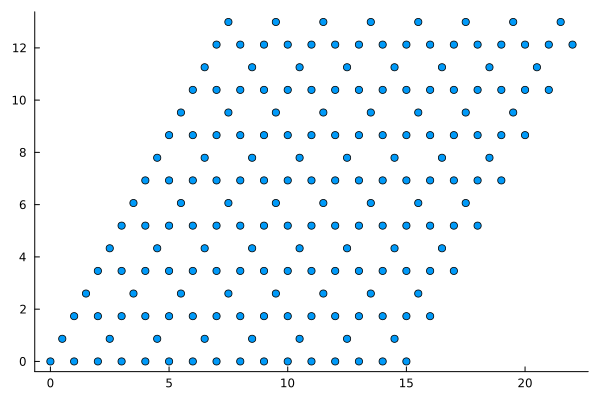

In [100]:
plot_kagome(Nx,Ny)

In [101]:
# Find x and y coordinates from gicen site index

function exp_list0(site_indx)
    
    x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:Nx*Ny*3)
    y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:Nx*Ny*3)
    
    x = hcat(x_co, y_co)[site_indx, 1]
    y = hcat(x_co, y_co)[site_indx, 2] 
    exp_val = real(expect_list)[site_indx] 
    
    return x, y, exp_val
end
exp_list0(1)

(0.0, 0.0, 0.012443285128497465)

In [102]:
# Find site_index from given x and y coordinates

function exp_list1(Xx, Yy)
    co_list = hcat(x_co, y_co)
    site_indx = intersect(findall(x->x==Xx, co_list[:,1]), findall(x->x==Yy, co_list[:,2]))
    return real(expect_list)[site_indx] 
end
x_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[4], 1:Nx*Ny*3)
y_co = OffsetArray(get_sites(Nx, Ny, a1_vec, a2_vec, Basis)[5], 1:Nx*Ny*3)
site_index = 5
Xx = x_co[site_index]
Yy = y_co[site_index]
print(site_index," => ",Xx,"\t",Yy," => ",exp_list1(Xx, Yy))

5 => 2.0	1.7320508075688772 => [0.004607568346564401]

In [103]:
AA = hcat(x_co, y_co)

192×2 Matrix{Any}:
  0.0   0.0
  1.0   0.0
  0.5   0.866025
  1.0   1.73205
  2.0   1.73205
  1.5   2.59808
  2.0   3.4641
  3.0   3.4641
  2.5   4.33013
  3.0   5.19615
  4.0   5.19615
  3.5   6.06218
  4.0   6.9282
  ⋮    
 18.0   6.9282
 19.0   6.9282
 18.5   7.79423
 19.0   8.66025
 20.0   8.66025
 19.5   9.52628
 20.0  10.3923
 21.0  10.3923
 20.5  11.2583
 21.0  12.1244
 22.0  12.1244
 21.5  12.9904

In [104]:
real(expect_list)

192-element Vector{Float64}:
 0.012443285128497465
 0.008263971175546598
 0.008177996802379794
 0.0049122739475464874
 0.004607568346564401
 0.0042419146364583715
 0.005982239731333109
 0.010366363345716847
 0.009010606731147423
 0.011699578349729773
 0.016709537891687373
 0.011673786492620398
 0.010223290789112495
 ⋮
 0.007939528798502972
 0.008770459594103561
 0.006036664594177832
 0.0047666121852575375
 0.004743091162848327
 0.0049470462201930574
 0.008472609601081127
 0.009308002632739293
 0.013283514697003156
 0.018785316886256818
 0.018679268073373986
 0.021167841032700432

In [106]:
reshape(real(expect_list), 16, 12)

16×12 Matrix{Float64}:
 0.0124433   0.00609837  0.0187399   …  0.0170198   0.0067273   0.00525128
 0.00826397  0.0066038   0.0203582      0.0202203   0.00809865  0.00691968
 0.008178    0.00937989  0.0216743      0.0156406   0.0076818   0.00908291
 0.00491227  0.00805749  0.0180117      0.012281    0.00676301  0.00823161
 0.00460757  0.0131726   0.0141241      0.0124228   0.00831454  0.00793953
 0.00424191  0.0156718   0.013015    …  0.00892512  0.0124183   0.00877046
 0.00598224  0.0119535   0.00921788     0.0060319   0.0157989   0.00603666
 0.0103664   0.0151979   0.00596741     0.00529585  0.0148207   0.00476661
 0.00901061  0.00551363  0.00482706     0.0067734   0.0204507   0.00474309
 0.0116996   0.00569083  0.00504933     0.00844293  0.0174193   0.00494705
 0.0167095   0.00494034  0.00592906  …  0.00802845  0.016299    0.00847261
 0.0116738   0.00622764  0.00529587     0.0118147   0.0105944   0.009308
 0.0102233   0.0090859   0.00717459     0.0130477   0.00737806  0.0132835
 0.01

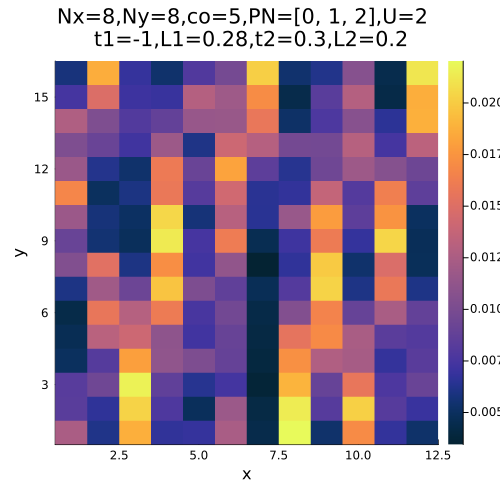

In [129]:
z = reshape(real(expect_list), 16, 12)
heatmap(z, c=:thermal, size=(500, 500), xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$PN,U=$U \n t1=$t1,L1=$L1,t2=$t2,L2=$L2"))

In [54]:
using PyPlot
Xx = AA[:,1];Yy = AA[:,2]
#pcolor(Xx, Yy, exp_list1(Xx,Yy))
pcolor(Xx, Yy, real(expect_list))

LoadError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\Can\.julia\packages\PyCall\twYvK\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('not enough values to unpack (expected 2, got 1)')
  File "C:\Users\Can\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\pyplot.py", line 2695, in pcolor
    __ret = gca().pcolor(
            ^^^^^^^^^^^^^
  File "C:\Users\Can\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\__init__.py", line 1433, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Can\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py", line 5903, in pcolor
    X, Y, C, shading = self._pcolorargs('pcolor', *args, shading=shading,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Can\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py", line 5672, in _pcolorargs
    nrows, ncols = C.shape
    ^^^^^^^^^^^^


In [44]:
Xx = AA[:,1];Yy = AA[:,2]
gr()
heatmap(Xx,Yy,exp_list1(Xx,Yy))

MethodError: MethodError: no method matching heatmap_edges(::Vector{Float64}, ::Symbol, ::Vector{Float64}, ::Symbol, ::Tuple{Int64}, ::Bool)
[0mClosest candidates are:
[0m  heatmap_edges(::AbstractVector, ::Symbol, ::AbstractVector, ::Symbol, [91m::Tuple{Int64, Int64}[39m, ::Bool) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:296
[0m  heatmap_edges(::AbstractVector, ::Symbol, ::AbstractVector, ::Symbol, [91m::Tuple{Int64, Int64}[39m) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:296
[0m  heatmap_edges(::AbstractVector, ::Symbol) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:286
[0m  ...

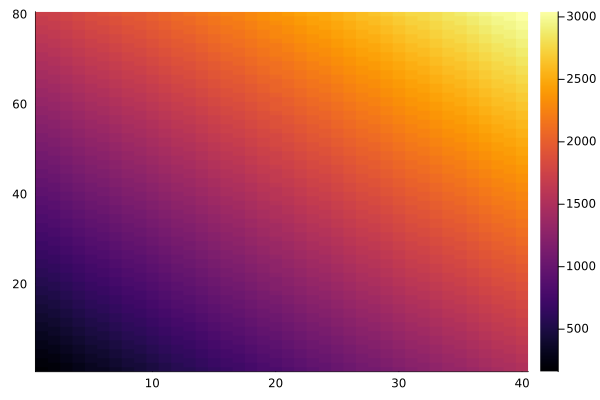

In [50]:
α = pi/3

# make some data
sz = (40, 80)
dat = reshape(1:prod(sz), sz)
x, y = axes(dat)

# performs rotation about center (or about c if provided)
# rounds and clamps the return value so it's a valid index
function rotate_coord(x, y, α, c = sz .÷ 2)
    x -= c[1]; y -= c[2]
    sα, cα = sincos(α)

    new_pt = (x*cα - y*sα, x*sα + y*cα) .+ c
    return clamp.(round.(Int, new_pt), 1, sz)
end 

# plot heatmap(x, y, f(x, y)).
heatmap(x, y, (x, y) -> dat[rotate_coord(x, y, α)...])

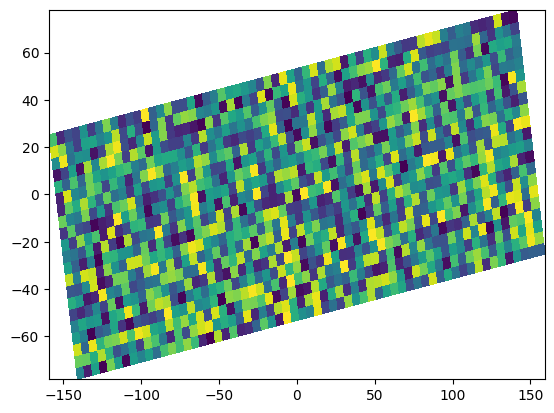

PyObject <matplotlib.collections.PolyCollection object at 0x00000000E2D3F050>

In [51]:
using PyPlot
α      = 10.0
lx, ly = 300.0, 100.0
nx, ny = 61, 21
(xc, yc ) = (LinRange(-lx/2, lx/2, nx), LinRange(-ly/2, ly/2, ny))
(Xc2,Yc2) = ([x for x=xc,y=yc], [y for x=xc,y=yc])
(X2r,Y2r) = (Xc2*cosd(α) - sind(α)*Yc2, Xc2*sind(α) + cosd(α)*Yc2)
pcolor(X2r, Y2r, rand(nx,ny))

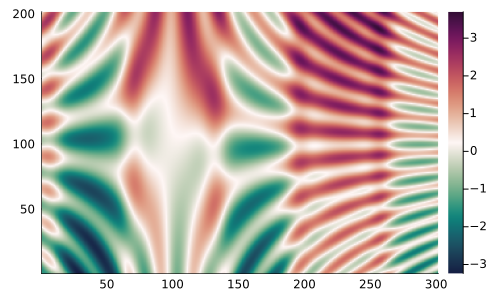

In [57]:
s=0.05
yl = range(-5, stop= 5, step=s)
xl = range(-5, stop= 10, step=s)
x = [xe for ye in yl, xe in xl]
y = [ye for ye in yl, xe in xl]
z = @. sin(x)^10 + cos(10 + y*x) + cos(x) + 0.2*y + 0.1*x
pl= heatmap(z, c=:curl, size=(500, 300))

In [59]:
z

201×301 Matrix{Float64}:
 -1.46261     -1.48913    -1.46408    …  -1.12686    -1.33107     -1.50374
 -1.53045     -1.49609    -1.41032       -0.626968   -0.841801    -1.05487
 -1.53726     -1.44219    -1.29955       -0.189934   -0.356753    -0.550158
 -1.482       -1.33011    -1.13779        0.0817317   0.00890192  -0.110732
 -1.36749     -1.16608    -0.934093       0.125213    0.168939     0.158273
 -1.20021     -0.959484   -0.700035   …  -0.0675275   0.0869813    0.193442
 -0.989952    -0.722298   -0.448998      -0.44782    -0.214675    -0.0113868
 -0.749164    -0.468371   -0.195377      -0.921969   -0.660473    -0.403615
 -0.492194    -0.212568    0.0462779     -1.37375    -1.13991     -0.884765
 -0.234399     0.0301297   0.262131      -1.6923     -1.53431     -1.33458
  0.00881435   0.245541    0.439887   …  -1.79876    -1.74565     -1.64049
  0.222947     0.421147    0.569527      -1.66516    -1.72026     -1.72515
  0.395306     0.546856    0.643905      -1.32118    -1.46186     -

In [ ]:
α      = 10.0
lx, ly = 300.0, 100.0
nx, ny = 61, 21
(xc, yc ) = (LinRange(-lx/2, lx/2, nx), LinRange(-ly/2, ly/2, ny))
(Xc2,Yc2) = ([x for x=xc,y=yc], [y for x=xc,y=yc])
(X2r,Y2r) = (Xc2*cosd(α) - sind(α)*Yc2, Xc2*sind(α) + cosd(α)*Yc2)
display(heatmap(X2r, Y2r, rand(nx,ny)'))

LoadError: MethodError: no method matching heatmap_edges(::Surface{Matrix{Float64}}, ::Symbol)
[0mClosest candidates are:
[0m  heatmap_edges([91m::AbstractVector[39m, ::Symbol) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:286
[0m  heatmap_edges([91m::AbstractVector[39m, ::Symbol, [91m::Bool[39m) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:286
[0m  heatmap_edges([91m::AbstractVector[39m, ::Symbol, [91m::Bool[39m, [91m::Bool[39m) at C:\Users\Can\.julia\packages\Plots\8K4be\src\utils.jl:286
[0m  ...

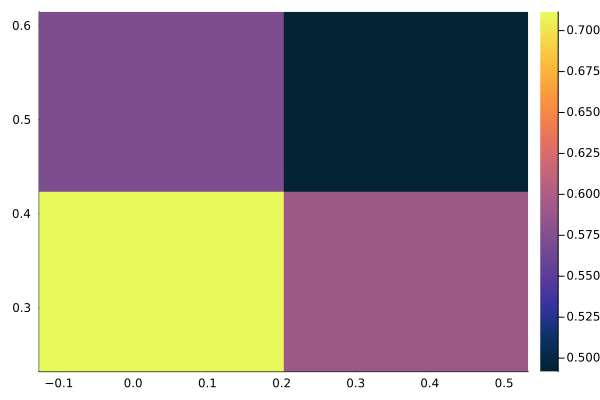

In [148]:
function f(x, y)
    r = sqrt(x^2 + y^2)
    return cos(r) / (1 + r)
end
x = sort(rand(2))
y = sort(rand(2))
heatmap(x, y, f, c = :thermal)

# Comparansion

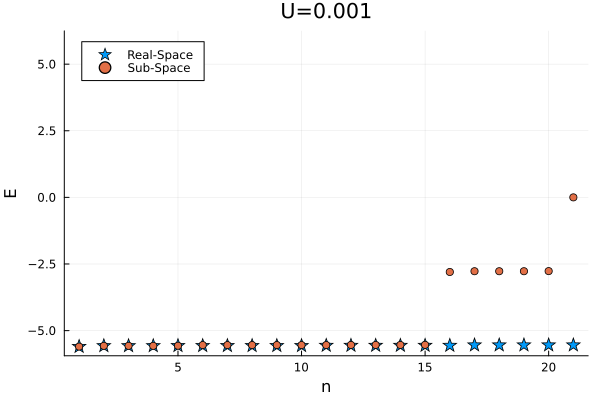

In [73]:
#U çok küçükken (Band-Gap büyüdüğünde) subspace enerjileri, real-space enerjilerine yakınsar:

using Plots

MB_Hamiltonian = Kagome_Finite_U(Nx,Ny,Basis_MB,U,sp_op)
real_space_finite_u = eigenenergies(dense(MB_Hamiltonian)); sub_space_finite_u = E_States[1]
plot(1:length(real_space_finite_u[1:21]),real_space_finite_u,seriestype=:scatter,markershape=:star5,markersize=7,label="Real-Space")
plot!(1:length(sub_space_finite_u),sub_space_finite_u,seriestype=:scatter,label="Sub-Space",legend=:topleft)
title!("U=$(U)");xlabel!("n");ylabel!("E")